In [6]:
import numpy as np
import matplotlib.pyplot as plt

class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.alpha = None
        self.left_prediction = None
        self.right_prediction = None

def build_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_stump = DecisionStump()
    min_error = float('inf')

    for feature in range(n_features):
        feature_values = X[:, feature]
        thresholds = np.unique(feature_values)
        for threshold in thresholds:
            left_mask = feature_values <= threshold
            right_mask = ~left_mask

            left_prediction = 1 if np.sum(weights[left_mask] * y[left_mask]) > 0 else -1
            right_prediction = 1 if np.sum(weights[right_mask] * y[right_mask]) > 0 else -1

            predictions = np.ones(n_samples)
            predictions[left_mask] = left_prediction
            predictions[right_mask] = right_prediction

            error = np.sum(weights * (predictions != y))

            if error > 0.5:
                error = 1 - error
                left_prediction *= -1
                right_prediction *= -1

            if error < min_error:
                min_error = error
                best_stump.feature_index = feature
                best_stump.threshold = threshold
                best_stump.left_prediction = left_prediction
                best_stump.right_prediction = right_prediction

    return best_stump, min_error

def stump_predict(X, stump):
    n_samples = X.shape[0]
    predictions = np.ones(n_samples)
    left_mask = X[:, stump.feature_index] <= stump.threshold
    predictions[left_mask] = stump.left_prediction
    predictions[~left_mask] = stump.right_prediction
    return predictions

def adaboost(X, y, X_test, y_test, T):
    n_samples, n_features = X.shape
    weights = np.ones(n_samples) / n_samples
    
    stumps = []
    weighted_train_errors = []
    unweighted_train_errors = []
    test_errors = []
    
    for t in range(T):
        stump, weighted_error = build_stump(X, y, weights)
        
        weighted_error = np.clip(weighted_error, 1e-15, 1 - 1e-15)
        
        stump.alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
        
        predictions = stump_predict(X, stump)
        weights *= np.exp(-stump.alpha * y * predictions)
        weights /= np.sum(weights)
        
        stumps.append(stump)
        
        weighted_train_errors.append(weighted_error)
        unweighted_train_error = np.mean(predictions != y)
        unweighted_train_errors.append(unweighted_train_error)
        
        test_error = np.mean(stump_predict(X_test, stump) != y_test)
        test_errors.append(test_error)
        
        if t % 10 == 0:
            print(f"Iteration {t+1}/{T}, Weighted Train Error: {weighted_error:.4f}, "
                  f"Unweighted Train Error: {unweighted_train_error:.4f}, Test Error: {test_error:.4f}")
    
    return stumps, weighted_train_errors, unweighted_train_errors, test_errors

def adaboost_predict(X, stumps):
    n_samples = X.shape[0]
    predictions = np.zeros(n_samples)
    for stump in stumps:
        predictions += stump.alpha * stump_predict(X, stump)
    return np.sign(predictions)

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', dtype=str)
    
    X = data[:, :-1]
    y = data[:, -1]
    
    X_encoded = np.zeros(X.shape, dtype=float)
    for i in range(X.shape[1]):
        try:
            X_encoded[:, i] = X[:, i].astype(float)
        except ValueError:
            unique_values = np.unique(X[:, i])
            X_encoded[:, i] = np.array([np.where(unique_values == val)[0][0] for val in X[:, i]])
    
    y = (y == 'yes').astype(int) * 2 - 1
    
    return X_encoded, y


Iteration 1/500, Weighted Train Error: 0.1106, Unweighted Train Error: 0.1106, Test Error: 0.1198
Iteration 11/500, Weighted Train Error: 0.4153, Unweighted Train Error: 0.8890, Test Error: 0.8804
Iteration 21/500, Weighted Train Error: 0.4526, Unweighted Train Error: 0.7372, Test Error: 0.7384
Iteration 31/500, Weighted Train Error: 0.4589, Unweighted Train Error: 0.4938, Test Error: 0.4848
Iteration 41/500, Weighted Train Error: 0.4681, Unweighted Train Error: 0.5558, Test Error: 0.5426
Iteration 51/500, Weighted Train Error: 0.4784, Unweighted Train Error: 0.7028, Test Error: 0.7098
Iteration 61/500, Weighted Train Error: 0.4714, Unweighted Train Error: 0.5418, Test Error: 0.5482
Iteration 71/500, Weighted Train Error: 0.4778, Unweighted Train Error: 0.7752, Test Error: 0.7786
Iteration 81/500, Weighted Train Error: 0.4774, Unweighted Train Error: 0.8152, Test Error: 0.8128
Iteration 91/500, Weighted Train Error: 0.4802, Unweighted Train Error: 0.4438, Test Error: 0.4554
Iteration 1

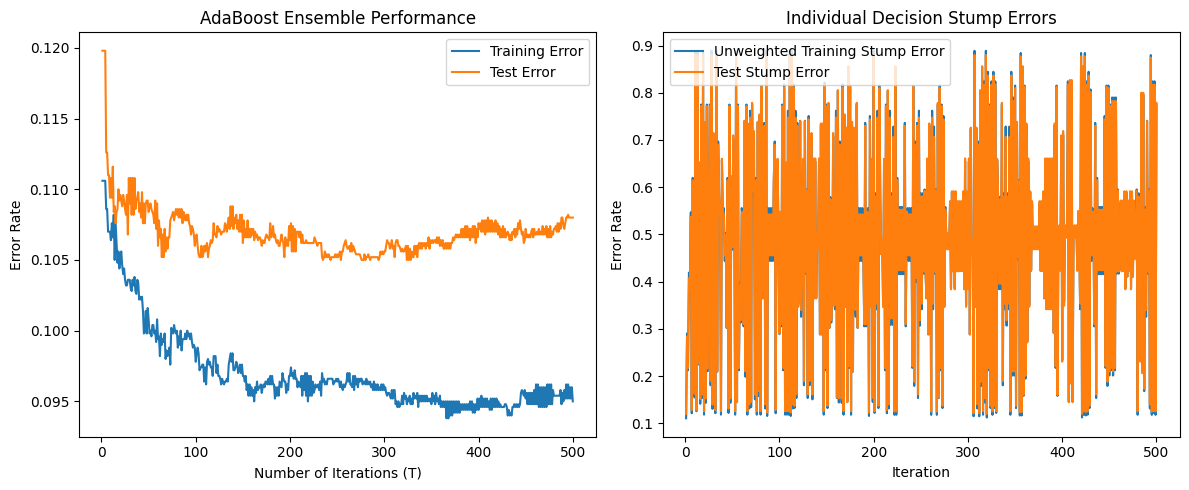

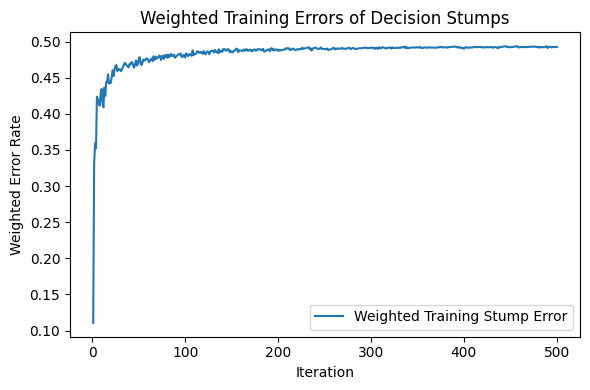

In [7]:
# Load and preprocess data
X_train, y_train = load_data('train_bank.csv')
X_test, y_test = load_data('test_bank.csv')

# Run AdaBoost
T = 500
stumps, weighted_train_errors, unweighted_train_errors, test_errors = adaboost(X_train, y_train, X_test, y_test, T)

# Calculate ensemble errors
train_ensemble_errors = []
test_ensemble_errors = []

for t in range(1, T + 1):
    train_preds = adaboost_predict(X_train, stumps[:t])
    test_preds = adaboost_predict(X_test, stumps[:t])
    
    train_error = np.mean(train_preds != y_train)
    test_error = np.mean(test_preds != y_test)
    
    train_ensemble_errors.append(train_error)
    test_ensemble_errors.append(test_error)
    
    if t % 50 == 0:
        print(f"Iteration {t}, Train Ensemble Error: {train_error:.4f}, Test Ensemble Error: {test_error:.4f}")

# Plot results
plt.figure(figsize=(12, 5))

# First figure: training and test errors of the ensemble varying along with T
plt.subplot(1, 2, 1)
plt.plot(range(1, T + 1), train_ensemble_errors, label='Training Error')
plt.plot(range(1, T + 1), test_ensemble_errors, label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title('AdaBoost Ensemble Performance')
plt.legend()

# Second figure: training and test errors of all decision stumps
plt.subplot(1, 2, 2)
plt.plot(range(1, T + 1), unweighted_train_errors, label='Unweighted Training Stump Error')
plt.plot(range(1, T + 1), test_errors, label='Test Stump Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title('Individual Decision Stump Errors')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot weighted training errors
plt.figure(figsize=(6, 4))
plt.plot(range(1, T + 1), weighted_train_errors, label='Weighted Training Stump Error')
plt.xlabel('Iteration')
plt.ylabel('Weighted Error Rate')
plt.title('Weighted Training Errors of Decision Stumps')
plt.legend()
plt.tight_layout()
plt.show()